In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from tqdm import tqdm 
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models
from models.model import ResNet50, ViTBase, CLIPModel
from models.utils import train_step, eval_step, DataLoaders, CIFAR100_Splits
from models.transforms import transforms_resnet,transforms_clip_vit,transforms_vit
import torch
import torch.nn as nn
from torchvision.datasets import CIFAR10, CIFAR100
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\PCF/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [23:07<00:00, 414kB/s]   


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
vgg.to(device)

True


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''

    image = Image.open(img_path).convert('RGB')

    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406),
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)

    return image

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import random
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load the CIFAR-10 training and test sets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Classes in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize to [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Fetch a random image from the dataset
def get_random_image(trainset):
    # Generate a random index
    random_idx = random.randint(0, len(trainset) - 1)
    # Fetch the image and its label
    image, label = trainset[random_idx]
    return image, label
def load_image_from_pil(image, max_size=400, shape=None):
    ''' Load in and transform a PIL Image, ensuring the image
        is resized appropriately. '''

    # Convert to RGB if not already
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Determine the new size based on max_size
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    # Define the transformation
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))
    ])

    # Apply the transformation
    image = in_transform(image)[:3, :, :].unsqueeze(0)  # Discard alpha channel and add batch dimension

    return image

Files already downloaded and verified
Files already downloaded and verified


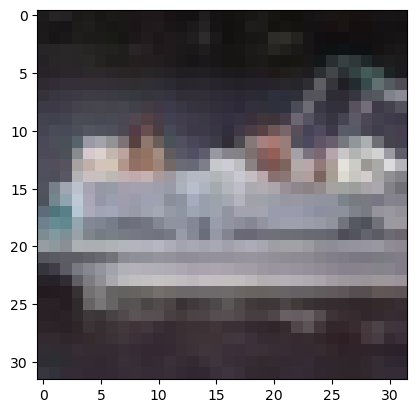

ship


In [ ]:
image, label = get_random_image(trainset)

# Show the random image
imshow(image)
print(classes[label])

In [ ]:
# load in content and style image
content = image.to(device)
# Resize style to match content, makes code easier
#curl --output starry_night.jpg 'https://img.freepik.com/premium-photo/immerse-enigmatic-beauty-starry-night-art-wallpaper-by-vincent-van-gogh-ar-32-desktop_983420-139572.jpg' 127.0.0.1:8000
style = load_image_from_pil(Image.open('starry_night.jpeg'), shape=content.shape[-2:]).to(device)

In [ ]:
def im_convert(tensor):
    """ Display a tensor as an image. """

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [ ]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """

    if layers is None:
        layers = {'0': 'conv1_1',
                 '5':  'conv2_1',
                 '10': 'conv3_1',
                 '19': 'conv4_1',
                 '21': 'conv4_2',
                 '28': 'conv5_1'}

    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

In [ ]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """

    gram = None
    b, d, h, w = tensor.size()
    tensor = tensor.view(d, h*w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [ ]:
# get content and style features only once before forming the target image
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start of with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

In [ ]:
# weights for each style layer
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

content_weight = 0.0005  # alpha
style_weight = 0.9995  # beta

In [ ]:
def stylizeFunc(target, content_features):
  # for displaying the target image, intermittently
  show_every = 100

  # iteration hyperparameters
  optimizer = optim.Adam([target], lr=0.5)
  steps = 100 # decide how many iterations to update your image (5000)
  with torch.no_grad():
    content_features = get_features(target, vgg)
  for ii in range(1, steps+1):
      ## Then calculate the content loss
      target_features = get_features(target, vgg)
      content_loss = torch.mean((target_features["conv4_2"] - content_features["conv4_2"]) ** 2)

      # the style loss
      # initialize the style loss to 0
      style_loss = 0
      # iterate through each style layer and add to the style loss
      for layer in style_weights:
          # get the "target" style representation for the layer
          target_feature = target_features[layer]
          target_feature = target_feature.unsqueeze(0)
          _, d, h, w = target_feature.shape
          target_gram = gram_matrix(target_feature)
          style_gram = style_grams[layer]
          layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)

          # add to the style loss
          style_loss += layer_style_loss / (d * h * w)

      total_loss = content_weight * content_loss + style_weight * style_loss

      # update your target image
      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()

      # display intermediate images and print the loss
      if  ii % show_every == 0 or ii == steps:
          print('',end='')
          # print('Total loss: ', total_loss.item())
          # plt.imshow(im_convert(target))
          # plt.show()
  return target

In [ ]:
from collections import defaultdict
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim
# Load CIFAR-10 dataset
transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))
    ])
cifar10 = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

# Number of images per class
num_images_per_class = 1000
class_images = defaultdict(list)

# Select 10 images from each class
for img, label in cifar10:

    if len(class_images[label]) < num_images_per_class:
        class_images[label].append(img)

Files already downloaded and verified


In [ ]:
# Stylizing images and constructing the new dataset
stylized_images = []
stylized_labels = []
i = 0
for label, images in class_images.items():
    for img in images:
        # Clone the image and stylize it
        img = img.to(device)
        target_image = img.clone().detach().requires_grad_(True).to(device)
        content_features = get_features(img, vgg)
        stylized_image = stylizeFunc(target_image, content_features)

        # Append the stylized image and its label to the dataset
        stylized_images.append(im_convert(stylized_image.cpu()))
        stylized_labels.append(label)
        i += 1
        plt.imsave(f'stylized_images/{label}/{i}.png', im_convert(stylized_image.cpu()))


# Convert to a PyTorch tensor dataset
stylized_dataset = list(zip(stylized_images, stylized_labels))

In [ ]:
stylized_images[0].shape

(224, 224, 3)